# Feedly Data Extraction Demo

Python 3

In [22]:
from feedly.client import *
from feedly import *
from newspaper import Article, ArticleException # http://newspaper.readthedocs.io/en/latest/
from time import sleep
import pandas as pd
import datetime
import math
pd.set_option('max_rows',300)

In [23]:
## IAP Crds
TOKEN = "A2zjasgZJawkY8etL3a9w1QP_BFLH7YcnaW_s-7kR7oU8Nkrz-ZY8spKj_rGuqYtyAJ4vYItikat_WS35cBCKA9jqYrbg_frpzLL_987_THA8BB4cXYfVGReSQMoScif6g7HI72_aKHYcheyqFVjObZX6QYiCZbrDAyzE1XvvvORiy8MjTSwRXQoX3in0_ywGYgFsfxJRA5M073PVSJJDv0Tv67JxC-GlvFRV3xiLqthS3Ed_8Qzztk:feedlydev"
FEEDLY_REDIRECT_URI = "http://fabreadly.com/auth_callback"
FEEDLY_CLIENT_ID="d8f62d80-bd91-4b23-bdc3-c219d0489a26"



# Load the Feed

Reference: [Feedly Documentation](https://developer.feedly.com/cloud/)

In [24]:
import json
import requests

# Feedly
feedaccess = TOKEN

## Use url below to get the feed ids. 
myurl = 'https://cloud.feedly.com/v3/subscriptions'
headers = {'Authorization': 'OAuth ' + feedaccess}
res = requests.get(url=myurl, headers=headers)
con = res.json()
output = json.dumps(con , indent=4)

# See all IAP Feeds and their IDs

From the API you can pull specific feeds by ID, or you can pull everything. One issue is that IAP is also a content generator and actually pushes things to Feedly, so you also end up pulling that stuff. Anything marked EWS, or ewsdata.rightsindevelopment.org or a link to that site is an IAP generated entry, we need to filter these out. We should be able to do this faitly easily with the metadata that is available for each item. Other option is pull from a bunch of different feeds, but my guess is that filtering will actually be easier. 

Code below shows all the different feeds - the ALL feed is not listed but is coded as an option in the `pull_feed` function.

In [25]:
def see_feeds(feedaccess=feedaccess):
    """
        Get the list of IAP feeds and the feed id - we need this when pulling the feed data. 
    """
    myurl = 'https://cloud.feedly.com/v3/subscriptions'
    headers = {'Authorization': 'OAuth ' + feedaccess}
    res = requests.get(url=myurl, headers=headers)
    con = res.json()
    output = json.dumps(con , indent=4)
    df = pd.DataFrame([(c['title'] , c['categories'][0]['id']) for c in con])
    df.columns = ['Title','id']
    return df, con

In [26]:
df, raw  = see_feeds(feedaccess)

In [27]:
df.head()

,Title,id
0,All - EWS,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
1,EWS SA,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
2,ADB,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
3,WB,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
4,"Title: World Bank, Text: Loan",user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...


In [28]:
def pull_feed(feed_id, feedcount, all_feeds=False,  feedaccess=feedaccess):
    """
    Pull the feed information from the Feedly API and returns a list of pulled JSON objects. 
    Returns a list in case we are pulling more then 1000 items, then we have multiple JSON objects. 
    
    feed_id: Id of the feed we want to pull from. (str)
    feedcount: Target number of items to pull from the feed. (int)
    all_feeds: If true then pulls all items in the IAP feed - value of feed_id will be ignored (Bool)
    feedaccess: Token Information (str)
    """
    
    feedcount = str(feedcount)
    current_count = 0
    continuation_rounds = math.ceil(int(feedcount) / 1000.0)
    json_data = []
    continuation_id = None
    if all_feeds:
        feed_id = 'user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/category/global.all'

    for i in range(continuation_rounds):
        print('Pulling Data - Round %s' % str(i+1))
        myurl = "http://cloud.feedly.com/v3/streams/contents?streamId=" + feed_id + "&count=" + feedcount
        
        if continuation_id:
            myurl += "&continuation={}".format(continuation_id)
        headers = {'Authorization': 'OAuth ' + feedaccess}
        res = requests.get(url=myurl, headers=headers)
        con = res.json()
        json_data.append(con)
        
        if int(feedcount) > 1000:
            print(con.keys())
            continuation_id = con['continuation']
    
    print('Complete')
    return json_data

In [29]:
pulled_json = pull_feed('',40,all_feeds=True)

Pulling Data - Round 1
Complete


In [30]:
pulled_json

[{'continuation': '163d523f672:5d1d03e:7cfe07d6',
  'id': 'user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/category/global.all',
  'items': [{'alternate': [{'href': 'https://leadership.ng/2018/06/06/oyo-gets-world-banks-500m-out-of-school-children-grant/',
      'type': 'text/html'}],
    'categories': [{'id': 'user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/category/World Bank',
      'label': 'NEWS WB- All Streams'}],
    'crawled': 1528301830126,
    'fingerprint': 'cd25c99d',
    'id': 'Q3GfCXNAnvqDp9m6Wwz54pZCbCVt0YoqzAnhHC5y8ag=_163d5e33fee:5eeb14b:2835af05',
    'keywords': ['[ grant intitle:"world bank" ]'],
    'origin': {'htmlUrl': 'https://news.google.coms/rss/search/section/q/%5B%20grant%20intitle:%22world%20bank%22%20%5D%20/%5B%20grant%20intitle:%22world%20bank%22%20%5D%20?ned=us&hl=en&gl=US',
     'streamId': 'feed/http://news.google.com/news?hl=en&gl=us&q=%5B%20grant%20intitle%3A%22world%20bank%22%20%5D%20&um=1&ie=UTF-8&output=rss',
     'title': '[ grant intitle:"world bank" ]  - G

# Process the Feed 

Convert to a dataframe

#TODO - Figure out what tags we need to preserve here - like from which news feed were they pulled - should be valuable for identifying the bank being mentioned.  

In [35]:
def process_pulled_data(json_data):
    df_data = []
    
    for grp in range(len(json_data)):
        data = json_data[grp]
        for i in range(len(data['items'])):

            vals = data['items'][i]
            article_data = []
            article_data += [vals['published'], vals['title'],vals['alternate'][0]['href']]
            try:
                article_data.append(vals['content']['content'])
            except:
                article_data.append(None)

            try:
                article_data.append(vals['summary']['content'])
            except:
                article_data.append(None)
            df_data.append(article_data)
        
        
    df = pd.DataFrame(df_data, columns=None)
    df.columns = ['published','title','url','content','summary']
    df.published = [datetime.datetime.fromtimestamp(i/1000.0) for i in df.published]
    return df

In [36]:
test_df = process_pulled_data(pulled_json)

In [37]:
test_df['keep'] = [False if 'ews.rightsindevelopment.org' in i else True for i in test_df.url]

In [38]:
test_df.keep.value_counts()

True     28
False    12
Name: keep, dtype: int64

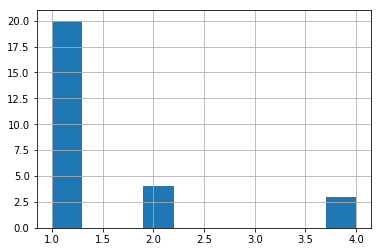

In [39]:
%matplotlib inline
test_df.url.value_counts().hist()

## Filter the Items 

In [40]:
#TODO

## Scrape the articles

**NOTE** - This is Slow - so may need to run in batches or overnight, or both. 

In [41]:
def get_text_via_Article(url):
    """
    Returns scraped article content - using the newspaper3k module (http://newspaper.readthedocs.io/en/latest/)
    """
    article = Article(url)
    article.download()
    try:
        article.parse()
    except ArticleException:
        print(url)
        article.download()
        print('sleeping')
        sleep(10)
    
        article.parse()
    return article.text

In [42]:
test_df['scraped_content'] = [get_text_via_Article(url) for url in test_df.url]

In [44]:
for i in test_df.head(5).scraped_content:
    print(i,'\n****')

European Union institution the European Investment Bank (EIB) has renewed its partnership with French port Marseille Fos under a €50 million funding agreement to support five key development projects.



The projects, which require a total investment of €136 million, include connecting the two existing Fos 2XL deepsea container terminals via a mid-section to provide a continuous quay length of 2.6km. Due to start this summer, the extension will increase capacity by 15-20 percent and improve berthing for ultra-large boxships.



Two other projects in the Fos western harbor area are also covered under the agreement – further development of the Feuillane logistics park and renovation of two ship refueling stations. Meanwhile, in the Marseille eastern harbor, the funding will go toward reorganization of the Corsica and North Africa ferry passenger terminals and enlargement of the Passe Nord access for mega cruise ships.



The agreement was signed on May 28 by Marseille Fos CEO Christine C

## Review Results and add in Some Language Detection

IAP only has content in English currently so tagging articles in other languages is likely too complicated at this time as it wold also involve a translation step. Therefore we may want to filter out non English language articles. 

In [45]:
from langdetect import detect_langs
from langdetect.lang_detect_exception import LangDetectException

In [48]:
for i in test_df.head().scraped_content:
    try:
        print(detect_langs(i))
    except LangDetectException:  
        continue
    print(i[0:300],
         '\n')
    print ('*******')

[en:0.9999952972346535]
European Union institution the European Investment Bank (EIB) has renewed its partnership with French port Marseille Fos under a €50 million funding agreement to support five key development projects.



The projects, which require a total investment of €136 million, include connecting the two exist 

*******
[en:0.9999991131684797]
India signed a USD 500 million (Rs 3,371 crore) loan pact with World Bank today to provide additional financing for PMGSY rural road projects.

The loan has a 3-year grace period, and a maturity of 10 years, the finance Ministry said in a release.

It will provide additional financing for the Pradha 

*******
[en:0.9999952599411848]
9700 Jamaican families enrolled in study

Data on fathers’ impact on child development collected for the first time

The UWI JA KIDS Birth Cohort Study Research Team will host a conference at the University of the West Indies from May 31 to June 1 to share ground-breaking findings from their seven-y 

***

# TODO 

1. Detect Language
2. Error Test on larger set
3. Manually verify extact is generally correct 
4. Extract article content for all articles in DataDive dataset (Could take a long time)
5. Method for Identifying articles previously scraped (we need a unique identifier so we can only scrape new articles in the future) -- This is just something to keep in mind. 

-------------------

# End